In [ ]:
!pip install spacy
!pip install tensorflow
!pip install keras
!pip install nltk
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from re import T
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import spacy

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Neccessary Exploratory and Preprocessing functions

In [ ]:
#Cleaning data function for the datasets

def clean_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))
      df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x))
      df[col] = df[col].apply(lambda x: x.lower())
  return df

#-----------------------------------------------------------------------------------------------
#Function to combine the all texts for classification
def combine_text(df):
  df['combined_text'] = df['postPlatform'] + ' ' + df['targetTitle'] + ' ' + df['targetDescription']  +  ' '  + df['postText']
  return df


#------------------------------------------------------------------------------------------------

#Sentence tokenizer function for the datasets
def sent_tokenize_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: sent_tokenize(x))

#-------------------------------------------------------------------------------------------------

#Word tokenizer function for the datasets
def word_tokenize_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: [word_tokenize(sent) for sent in x])


#--------------------------------------------------------------------------------------------------

#Function to remove listings
def remove_listing(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: ' '.join([item for sublist in x for item in sublist]) \
                              if isinstance(x, list) else x)
  return df

#---------------------------------------------------------------------------------------------------

#Function for removing stopwords in datasets
def remove_stopwords(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      stop_words = set(stopwords.words('english'))
      df[col] = df[col].apply(lambda x: [[word for word in sent if word not in stop_words] for sent in x])

#------------------------------------------------------------------------------------------------------


#Lemmatization
#POS tag function for lemmatization
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def lemmatize_data(df):
  lemmatizer = WordNetLemmatizer()
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: [[lemmatizer.lemmatize(word, get_wordnet_pos(pos)) \
                                          if get_wordnet_pos(pos) else word for word, pos in \
                                          pos_tag(sent)] for sent in x])
  return df


#--------------------------------------------------------------------------------------------------------

#Spacy for Cleaning
def preprocess_text(text):
  doc = nlp(text.lower())
  cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
  return cleaned_text

#--------------------------------------------------------------------------------------------------------

#Tokenize and pad sequences for the features
def padding_data(Train_df, Val_df, Test_df):
  tokenizer = Tokenizer(num_words=10000)
  tokenizer.fit_on_texts(Train_df['combined_text'])
  X1 = tokenizer.texts_to_sequences(Train_df['combined_text'])
  X_train = pad_sequences(X1, padding= 'post', maxlen=100)
  X2 = tokenizer.texts_to_sequences(Val_df['combined_text'])
  X_val = pad_sequences(X2, padding= 'post', maxlen=100)
  X3 = tokenizer.texts_to_sequences(Test_df['combined_text'])
  X_test = pad_sequences(X3, padding= 'post', maxlen=100)
  return X_train, X_val, X_test


#--------------------------------------------------------------------------------------------------------

#Encoder for the target variable
label_encoder = LabelEncoder()
def encoding_data(Train_df, Val_df, Test_df):
  label_encoder = LabelEncoder()
  y1 = label_encoder.fit_transform(Train_df['tags'])
  y2 = label_encoder.transform(Val_df['tags'])
  y3 = label_encoder.transform(Test_df['tags'])
  y_train = to_categorical(y1, num_classes=3)
  y_val = to_categorical(y2, num_classes=3)
  y_test = to_categorical(y3, num_classes=3)
  return y_train, y_val, y_test


#--------------------------------------------------------------------------------------------------------
#Transformer
  def transformer_block(inputs, num_heads, ff_dim):
    #Multihead Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)

    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    #Feedforward layer
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(attention_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)

    transformer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return transformer_output


In [ ]:
#Load the datasets

Train_df = pd.read_json('/content/sample_data/train.jsonl', lines=True)
Val_df = pd.read_json('/content/sample_data/validation.jsonl', lines=True)
Test_df = pd.read_json('/content/sample_data/test.jsonl', lines=True)

In [ ]:
#A peep into the datasets
Train_df.head(3)

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[Wes Welker Wanted Dinner With Tom Brady, But ...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[how about that morning we go throw?],"[[[3, 151], [3, 186]]]",[passage]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,[NASA sets date for full recovery of ozone hole],Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",[phrase]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,[This is what makes employees happy -- and it'...,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",[intellectual stimulation],"[[[1, 186], [1, 210]]]",[phrase]


In [ ]:
Val_df.head(3)

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,6dc7ddef-4e8e-4a6b-9296-526377518071,800048986762423_885081814925806,[Five Nights at Freddy’s Sequel Delayed for We...,Facebook,[Five Nights at Freddy’s creator Scott Cawthon...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy's creator Scott Cawthon ...,None,[https://gamerant.com/wp-content/uploads/five-...,https://gamerant.com/five-nights-at-freddys-se...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[some of the plot elements are so disturbing t...,"[[[2, 158], [2, 236]]]",[passage]
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,4jp20e,[Why Arizona Sheriff Joe Arpaio’s fate could h...,reddit,[© REUTERS/Laura Segall Maricopa County Sherif...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"<p>A single word — ""intentionally"" — could tra...",None,[https://archive.is/0eGBT/bbf6d79b366fc7e75b8b...,https://archive.is/0eGBT,"{'source': 'anonymized', 'humanSpoiler': '""Int...","[""intentionally"", could transform a court case...","[[[0, 197], [0, 212]], [[0, 215], [0, 328]]]",[multi]
2,8091ba93-6376-473a-9117-01d6cf0507e4,857559227384160256,[Here’s how much you should be tipping your ha...,Twitter,[Here’s how much you should be tipping your ha...,Here’s how much you should be tipping your hai...,Remembering how much you’re supposed to tip an...,,None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[20%],"[[[3, 58], [3, 61]]]",[phrase]


In [ ]:
Test_df.head(3)

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,2f3e30d7-972c-4812-b727-6b582de52137,420585068076101633,[This simple household item saves lives],Twitter,[Erin Zaikis often used to think about how she...,The Simple Household Item This 24-Year-Old Is ...,Erin Zaikis often used to think about how she ...,"go giver,the third metric,go-givers,sundara so...",[http://i.huffpost.com/gen/1546495/thumbs/s-SU...,http://huff.to/1cN9JfJ,"{'source': 'anonymized', 'humanSpoiler': 'Soap...",[soap],"[[[4, 188], [4, 192]]]",[phrase]
1,45425f74-4c0e-420c-aea8-6337ea91e107,4km87q,[You'll Never Believe Who Robert Downey Jr.'s ...,reddit,"[We weren't expecting this one!, On Wednesday,...",You'll Never Believe Who Robert Downey Jr.'s '...,It's not uncommon for couples to have free pas...,"celebrity gossip, Hollywood gossip, juicy cele...",[http://i.perezhilton.com/wp-content/uploads/2...,http://perezhilton.com/2016-05-04-robert-downe...,"{'source': 'anonymized', 'humanSpoiler': 'Gwyn...",[Gwyneth Paltrow],"[[[4, 68], [4, 83]]]",[phrase]
2,2fb84020-cfdb-4b7f-9cfc-b891c306c946,4s4f3b,[THE NEWEST THEORY ON HIDDLESWIFT'S ROMANCE IS...,reddit,"[This whole Taylor Swift, Tom Hiddleston thing...",The Newest Theory on Hiddleswift's Romance Is ...,We've done some serious investigative journali...,"taylor swift, tom hiddleston, nicholas sparks,...",[http://hbz.h-cdn.co/assets/harpersbazaar/2017...,http://www.harpersbazaar.com/celebrity/latest/...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[filming the next Nicholas Sparks film],"[[[2, 170], [2, 207]]]",[passage]


In [ ]:
#Shape of datasets
print("Training data shape:", Train_df.shape)
print("Validation data shape:", Val_df.shape)
print("Testing data shape:", Test_df.shape)

Training data shape: (3200, 14)
Validation data shape: (800, 14)
Testing data shape: (1000, 14)


In [ ]:
#A look into details of the Dataset columns
print("Train Dataset:")
Train_df.info()

Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               3200 non-null   object
 1   postId             3200 non-null   object
 2   postText           3200 non-null   object
 3   postPlatform       3200 non-null   object
 4   targetParagraphs   3200 non-null   object
 5   targetTitle        3200 non-null   object
 6   targetDescription  2933 non-null   object
 7   targetKeywords     2116 non-null   object
 8   targetMedia        2685 non-null   object
 9   targetUrl          2717 non-null   object
 10  provenance         3200 non-null   object
 11  spoiler            3200 non-null   object
 12  spoilerPositions   3200 non-null   object
 13  tags               3200 non-null   object
dtypes: object(14)
memory usage: 350.1+ KB


In [ ]:
print("Validation Dataset:")
Val_df.info()

Validation Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               800 non-null    object
 1   postId             800 non-null    object
 2   postText           800 non-null    object
 3   postPlatform       800 non-null    object
 4   targetParagraphs   800 non-null    object
 5   targetTitle        800 non-null    object
 6   targetDescription  730 non-null    object
 7   targetKeywords     510 non-null    object
 8   targetMedia        675 non-null    object
 9   targetUrl          683 non-null    object
 10  provenance         800 non-null    object
 11  spoiler            800 non-null    object
 12  spoilerPositions   800 non-null    object
 13  tags               800 non-null    object
dtypes: object(14)
memory usage: 87.6+ KB


In [ ]:
print("Test Dataset:")
Test_df.info()

Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               1000 non-null   object
 1   postId             1000 non-null   object
 2   postText           1000 non-null   object
 3   postPlatform       1000 non-null   object
 4   targetParagraphs   1000 non-null   object
 5   targetTitle        1000 non-null   object
 6   targetDescription  917 non-null    object
 7   targetKeywords     669 non-null    object
 8   targetMedia        840 non-null    object
 9   targetUrl          854 non-null    object
 10  provenance         1000 non-null   object
 11  spoiler            1000 non-null   object
 12  spoilerPositions   1000 non-null   object
 13  tags               1000 non-null   object
dtypes: object(14)
memory usage: 109.5+ KB


In [ ]:
#A look into details of the Dataset columns
print("Train Dataset:")
Train_df.describe()

Train Dataset:


,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
count,3200,3200,3200,3200,3200,3200,2933,2116,2685,2717,3200,3200,3200,3200
unique,3200,3200,3186,3,3184,3168,2813,1795,2663,2716,2632,3147,3057,3
top,5b61d712-8b03-4ee6-ba04-b39ce2b206f7,387429931400953856,[10 things you need to know before the opening...,Twitter,[She enjoyed riding horses and making adorable...,10 things you need to know before the opening ...,,,"[http://:0, http://unvis.it/img/patreon.png, h...",http://archive.is/uK0Ts,"{'source': 'anonymized', 'humanSpoiler': None,...",[California],"[[[0, 0], [0, 11]]]",[phrase]
freq,1,1,3,1530,2,3,65,230,5,2,513,6,11,1367


In [ ]:
print("Validation Dataset:")
Val_df.describe()

Validation Dataset:


,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
count,800,800,800,800,800,800,730,510,675,683,800,800,800,800
unique,800,800,799,3,800,798,719,454,675,683,672,798,789,3
top,89da1992-572d-45dc-97e4-c07a18febfb7,826900435197898753,[10 things you need to know before the opening...,Twitter,[Some Twitter users are joking about President...,10 things you need to know before the opening ...,,,[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/19m7Itl,"{'source': 'anonymized', 'humanSpoiler': None,...",[pizza],"[[[0, 0], [0, 14]]]",[phrase]
freq,1,1,2,367,1,2,8,40,1,1,124,2,3,335


In [ ]:
print("Test Dataset:")
Test_df.describe()

Test Dataset:


,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
count,1000,1000,1000,1000,1000,1000,917,669,840,854,1000,1000,1000,1000
unique,1000,1000,1000,3,998,996,887,565,838,854,828,992,984,3
top,2c8ce9f1-8571-4bc5-9ede-a86f14dbb16f,705553853236781056,[You'll never guess Rob Lowe's weird favorite ...,Twitter,"[In a class I had with her, she opened up abou...",9-Year-Old Asks ‘Am I Not Pretty Enough?’ Then...,,,[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://gq.mn/6oaC9dl,"{'source': 'anonymized', 'humanSpoiler': None,...",[Money],"[[[0, 0], [0, 15]]]",[phrase]
freq,1,1,1,482,2,2,21,83,2,1,158,3,2,423


In [ ]:
#A look into details of the Dataset columns
print("Train Dataset:")
print(Train_df.columns)
print("Validation Dataset:")
print(Val_df.columns)
print("Test Dataset:")
print(Test_df.columns)

Train Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')
Validation Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')
Test Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')


In [ ]:
#Drop unimportant columns
to_drop = ['uuid', 'postId', 'targetKeywords', 'targetMedia','targetUrl', 'provenance', 'spoiler', 'spoilerPositions']


Train_df.drop(to_drop, inplace=True, axis=1)
Val_df.drop(to_drop, inplace=True, axis=1)
Test_df.drop(to_drop, inplace=True, axis=1)

In [ ]:
#Removing listing from the datasets
Train_df = Train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
Val_df = Val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
Test_df = Test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)

<ipython-input-19-d5bafa6ab177>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Train_df = Train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
<ipython-input-19-d5bafa6ab177>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Val_df = Val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
<ipython-input-19-d5bafa6ab177>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Test_df = Test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)


In [ ]:
print("Train Dataset:")
Train_df.head(5)

Train Dataset:


,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",reddit,It’ll be just like old times this weekend for ...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,passage
1,NASA sets date for full recovery of ozone hole,Twitter,2070 is shaping up to be a great year for Moth...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,phrase
2,This is what makes employees happy -- and it's...,Twitter,"Despite common belief, money isn't the key to ...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,phrase
3,Passion is overrated — 7 work habits you need ...,Twitter,"It’s common wisdom. Near gospel really, and no...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,multi
4,The perfect way to cook rice so that it's perf...,Twitter,"Boiling rice may seem simple, but there is a v...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,phrase


In [ ]:
print("Validation Dataset:")
Val_df.head(5)

Validation Dataset:


,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,Five Nights at Freddy’s Sequel Delayed for Wei...,Facebook,Five Nights at Freddy’s creator Scott Cawthon ...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy's creator Scott Cawthon ...,passage
1,Why Arizona Sheriff Joe Arpaio’s fate could ha...,reddit,© REUTERS/Laura Segall Maricopa County Sheriff...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"<p>A single word — ""intentionally"" — could tra...",multi
2,Here’s how much you should be tipping your hai...,Twitter,Here’s how much you should be tipping your hai...,Here’s how much you should be tipping your hai...,Remembering how much you’re supposed to tip an...,phrase
3,"""Harry Potter"" alums reunite for new movie",Twitter,The mythology of punk music's evolution can be...,"Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...",The mythology of punk music's evolution can be...,multi
4,A man swallowed a microSD card and you won't b...,Twitter,PetaPixel is one of my favorite blogs. The wri...,Man swallowed a microSD card and you won't bel...,PetaPixel is one of my favorite blogs. The wri...,passage


In [ ]:
print("Test Dataset:")
Test_df.head(5)

Test Dataset:


,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,This simple household item saves lives,Twitter,Erin Zaikis often used to think about how she ...,The Simple Household Item This 24-Year-Old Is ...,Erin Zaikis often used to think about how she ...,phrase
1,You'll Never Believe Who Robert Downey Jr.'s '...,reddit,"We weren't expecting this one!On Wednesday, Ro...",You'll Never Believe Who Robert Downey Jr.'s '...,It's not uncommon for couples to have free pas...,phrase
2,THE NEWEST THEORY ON HIDDLESWIFT'S ROMANCE IS ...,reddit,"This whole Taylor Swift, Tom Hiddleston thing ...",The Newest Theory on Hiddleswift's Romance Is ...,We've done some serious investigative journali...,passage
3,NBA Star surprises an inner-city youth basketb...,Twitter,"While spending his summer in Los Angeles, Denv...",NBA Player JaVale McGee Gives Pep Talk To A Bo...,"While spending his summer in Los Angeles, Denv...",multi
4,"The little girl from ""Titanic"" is all grown up...",Twitter,I believe that the cute does go on.1. Remember...,"The Little Girl From ""Titanic"" Is All Grown Up...",,phrase


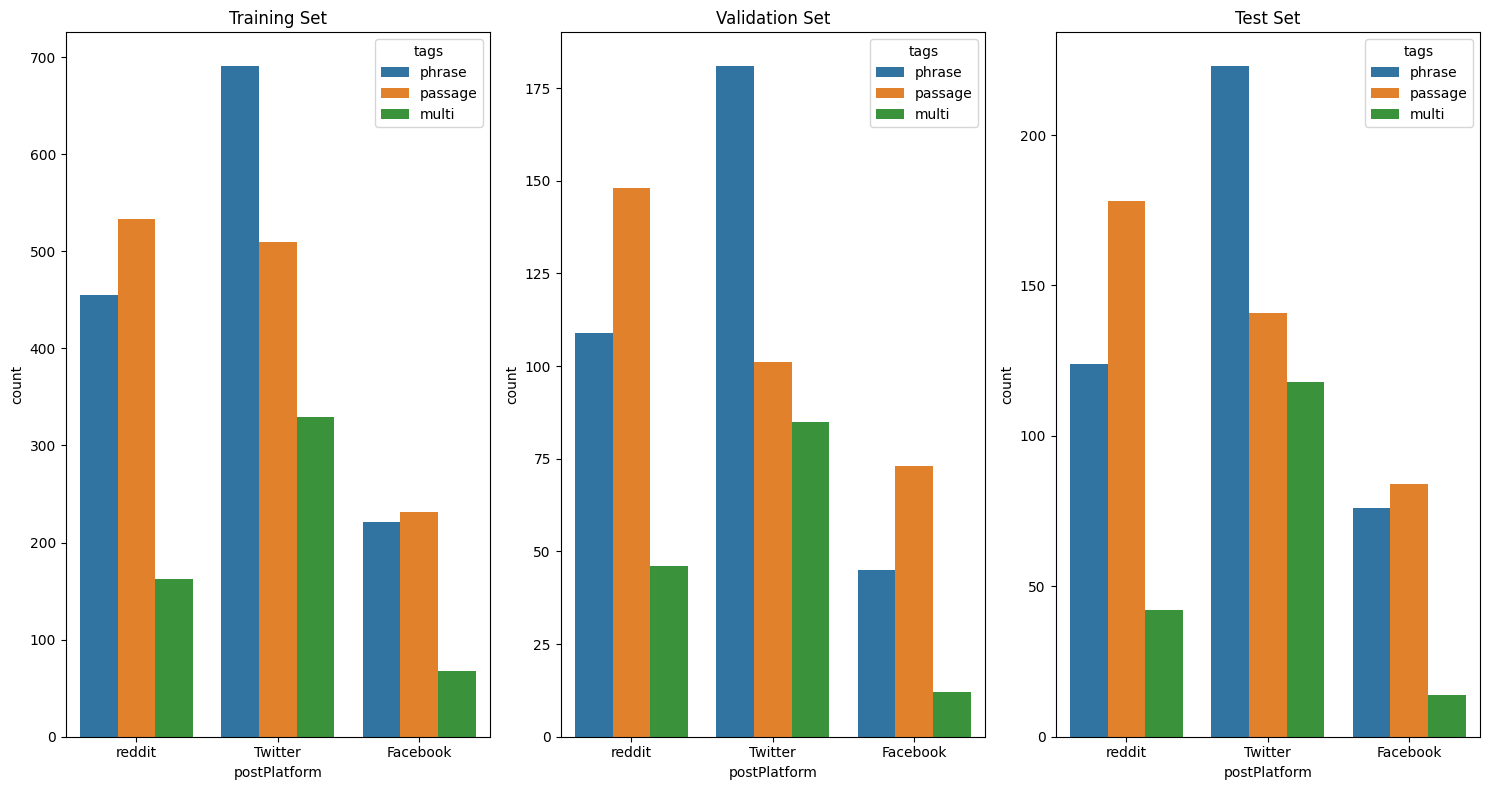

In [ ]:
#Visualisation of the type of spoilers by platform
category_order = ['reddit', 'Twitter', 'Facebook']
hue_order = ['phrase', 'passage', 'multi']


fig, ax = plt.subplots(1,3, figsize=(15, 8))

sns.countplot(x='postPlatform', data=Train_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[0])
ax[0].set_title('Training Set')

sns.countplot(x='postPlatform', data=Val_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[1])
ax[1].set_title('Validation Set')

sns.countplot(x='postPlatform', data=Test_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[2])
ax[2].set_title('Test Set')

fig.tight_layout()
plt.show()

In [ ]:
#Checking sum of null values in each Training columns
Train_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,267
tags,0


In [ ]:
#Dropping null values in the 'targetDescription' column
Train_df = Train_df.dropna(subset=['targetDescription'])

In [ ]:
#Confirming no null values in the Training Dataset
Train_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,0
tags,0


In [ ]:
#Checking the unique values in each column
Train_df.nunique()

,0
postText,2919
postPlatform,3
targetParagraphs,2918
targetTitle,2903
targetDescription,2813
tags,3


In [ ]:
#Checking sum of null values in each Validation columns
Val_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,70
tags,0


In [ ]:
#Dropping null values in the validation set
Val_df = Val_df.dropna(subset=['targetDescription'])

In [ ]:
#Confirming no null values in the Validation Dataset
Val_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,0
tags,0


In [ ]:
#Checking the unique values in each column of validation set
Val_df.nunique()

,0
postText,729
postPlatform,3
targetParagraphs,730
targetTitle,728
targetDescription,719
tags,3


In [ ]:
#Checking sum of null values in each Test columns
Test_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,83
tags,0


In [ ]:
#Dropping null values in the test set
Test_df = Test_df.dropna(subset=['targetDescription'])

In [ ]:
#Confirming no null values in the Test Dataset
Test_df.isnull().sum()

,0
postText,0
postPlatform,0
targetParagraphs,0
targetTitle,0
targetDescription,0
tags,0


In [ ]:
#Checking the unique values in each column of Test set
Test_df.nunique()

,0
postText,917
postPlatform,3
targetParagraphs,916
targetTitle,913
targetDescription,887
tags,3


# **PREPROCESSING**

In [ ]:
#Removing special characters and changing the Training dataset to lower case
Train2 = Train_df.copy()
clean_train = clean_data(Train2)
clean_train.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,wes welker wanted dinner with tom brady but pa...,reddit,it ll be just like old times this weekend for ...,wes welker wanted dinner with tom brady but pa...,it ll be just like old times this weekend for ...,passage
1,nasa sets date for full recovery of ozone hole,twitter,2070 is shaping up to be a great year for moth...,hole in ozone layer expected to make full reco...,2070 is shaping up to be a great year for moth...,phrase
2,this is what makes employees happy and it s no...,twitter,despite common belief money isn t the key to e...,intellectual stimulation trumps money for empl...,by chad brooks published 09 18 2013 06 40 am e...,phrase


In [ ]:
#Create sentence tokenization of the Training dataset
sent_tokenize_data(clean_train)
clean_train.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,[wes welker wanted dinner with tom brady but p...,[reddit],[it ll be just like old times this weekend for...,[wes welker wanted dinner with tom brady but p...,[it ll be just like old times this weekend for...,[passage]
1,[nasa sets date for full recovery of ozone hole],[twitter],[2070 is shaping up to be a great year for mot...,[hole in ozone layer expected to make full rec...,[2070 is shaping up to be a great year for mot...,[phrase]
2,[this is what makes employees happy and it s n...,[twitter],[despite common belief money isn t the key to ...,[intellectual stimulation trumps money for emp...,[by chad brooks published 09 18 2013 06 40 am ...,[phrase]


In [ ]:
#Tokenize each word in for each tokenized Training sentence
word_tokenize_data(clean_train)
clean_train.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[wes, welker, wanted, dinner, with, tom, brad...",[[reddit]],"[[it, ll, be, just, like, old, times, this, we...","[[wes, welker, wanted, dinner, with, tom, brad...","[[it, ll, be, just, like, old, times, this, we...",[[passage]]
1,"[[nasa, sets, date, for, full, recovery, of, o...",[[twitter]],"[[2070, is, shaping, up, to, be, a, great, yea...","[[hole, in, ozone, layer, expected, to, make, ...","[[2070, is, shaping, up, to, be, a, great, yea...",[[phrase]]
2,"[[this, is, what, makes, employees, happy, and...",[[twitter]],"[[despite, common, belief, money, isn, t, the,...","[[intellectual, stimulation, trumps, money, fo...","[[by, chad, brooks, published, 09, 18, 2013, 0...",[[phrase]]


In [ ]:
#Remove stopwords from the Training dataset
remove_stopwords(clean_train)
clean_train.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[wes, welker, wanted, dinner, tom, brady, pat...",[[reddit]],"[[like, old, times, weekend, tom, brady, wes, ...","[[wes, welker, wanted, dinner, tom, brady, pat...","[[like, old, times, weekend, tom, brady, wes, ...",[[passage]]
1,"[[nasa, sets, date, full, recovery, ozone, hole]]",[[twitter]],"[[2070, shaping, great, year, mother, earth, n...","[[hole, ozone, layer, expected, make, full, re...","[[2070, shaping, great, year, mother, earth, n...",[[phrase]]
2,"[[makes, employees, happy, paycheck]]",[[twitter]],"[[despite, common, belief, money, key, employe...","[[intellectual, stimulation, trumps, money, em...","[[chad, brooks, published, 09, 18, 2013, 06, 4...",[[phrase]]


In [ ]:
#Removing special characters and changing the Validation dataset to lower case
Val2 = Val_df.copy()
clean_val = clean_data(Val2)
clean_val.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,five nights at freddy s sequel delayed for wei...,facebook,five nights at freddy s creator scott cawthon ...,five nights at freddy s sequel delayed for wei...,five nights at freddy s creator scott cawthon ...,passage
1,why arizona sheriff joe arpaio s fate could ha...,reddit,reuters laura segall maricopa county sheriff ...,why arizona sheriff joe arpaio s fate could ha...,p a single word intentionally could transform...,multi
2,here s how much you should be tipping your hai...,twitter,here s how much you should be tipping your hai...,here s how much you should be tipping your hai...,remembering how much you re supposed to tip an...,phrase


In [ ]:
#Create sentence tokenization of the validation dataset
sent_tokenize_data(clean_val)
clean_val.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,[five nights at freddy s sequel delayed for we...,[facebook],[five nights at freddy s creator scott cawthon...,[five nights at freddy s sequel delayed for we...,[five nights at freddy s creator scott cawthon...,[passage]
1,[why arizona sheriff joe arpaio s fate could h...,[reddit],[ reuters laura segall maricopa county sheriff...,[why arizona sheriff joe arpaio s fate could h...,[ p a single word intentionally could transfor...,[multi]
2,[here s how much you should be tipping your ha...,[twitter],[here s how much you should be tipping your ha...,[here s how much you should be tipping your ha...,[remembering how much you re supposed to tip a...,[phrase]


In [ ]:
#Tokenize each word in for each tokenized validation sentences
word_tokenize_data(clean_val)
clean_val.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[five, nights, at, freddy, s, sequel, delayed...",[[facebook]],"[[five, nights, at, freddy, s, creator, scott,...","[[five, nights, at, freddy, s, sequel, delayed...","[[five, nights, at, freddy, s, creator, scott,...",[[passage]]
1,"[[why, arizona, sheriff, joe, arpaio, s, fate,...",[[reddit]],"[[reuters, laura, segall, maricopa, county, sh...","[[why, arizona, sheriff, joe, arpaio, s, fate,...","[[p, a, single, word, intentionally, could, tr...",[[multi]]
2,"[[here, s, how, much, you, should, be, tipping...",[[twitter]],"[[here, s, how, much, you, should, be, tipping...","[[here, s, how, much, you, should, be, tipping...","[[remembering, how, much, you, re, supposed, t...",[[phrase]]


In [ ]:
#Remove stopwords from the validation dataset
remove_stopwords(clean_val)
clean_val.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[five, nights, freddy, sequel, delayed, weird...",[[facebook]],"[[five, nights, freddy, creator, scott, cawtho...","[[five, nights, freddy, sequel, delayed, weird...","[[five, nights, freddy, creator, scott, cawtho...",[[passage]]
1,"[[arizona, sheriff, joe, arpaio, fate, could, ...",[[reddit]],"[[reuters, laura, segall, maricopa, county, sh...","[[arizona, sheriff, joe, arpaio, fate, could, ...","[[p, single, word, intentionally, could, trans...",[[multi]]
2,"[[much, tipping, hairdresser]]",[[twitter]],"[[much, tipping, hairdressermoreremembering, m...","[[much, tipping, hairdresser]]","[[remembering, much, supposed, tip, anywhere, ...",[[phrase]]


In [ ]:
#Removing special characters and changing the Test dataset to lower case
Test2 = Test_df.copy()
clean_test = clean_data(Test2)
clean_test.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,this simple household item saves lives,twitter,erin zaikis often used to think about how she ...,the simple household item this 24 year old is ...,erin zaikis often used to think about how she ...,phrase
1,you ll never believe who robert downey jr s fr...,reddit,we weren t expecting this one on wednesday rob...,you ll never believe who robert downey jr s fr...,it s not uncommon for couples to have free pas...,phrase
2,the newest theory on hiddleswift s romance is ...,reddit,this whole taylor swift tom hiddleston thing j...,the newest theory on hiddleswift s romance is ...,we ve done some serious investigative journali...,passage


In [ ]:
#Create sentence tokenization of the Test dataset
sent_tokenize_data(clean_test)
clean_test.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,[this simple household item saves lives],[twitter],[erin zaikis often used to think about how she...,[the simple household item this 24 year old is...,[erin zaikis often used to think about how she...,[phrase]
1,[you ll never believe who robert downey jr s f...,[reddit],[we weren t expecting this one on wednesday ro...,[you ll never believe who robert downey jr s f...,[it s not uncommon for couples to have free pa...,[phrase]
2,[the newest theory on hiddleswift s romance is...,[reddit],[this whole taylor swift tom hiddleston thing ...,[the newest theory on hiddleswift s romance is...,[we ve done some serious investigative journal...,[passage]


In [ ]:
#Tokenize each word in for each tokenized test sentences
word_tokenize_data(clean_test)
clean_test.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[this, simple, household, item, saves, lives]]",[[twitter]],"[[erin, zaikis, often, used, to, think, about,...","[[the, simple, household, item, this, 24, year...","[[erin, zaikis, often, used, to, think, about,...",[[phrase]]
1,"[[you, ll, never, believe, who, robert, downey...",[[reddit]],"[[we, weren, t, expecting, this, one, on, wedn...","[[you, ll, never, believe, who, robert, downey...","[[it, s, not, uncommon, for, couples, to, have...",[[phrase]]
2,"[[the, newest, theory, on, hiddleswift, s, rom...",[[reddit]],"[[this, whole, taylor, swift, tom, hiddleston,...","[[the, newest, theory, on, hiddleswift, s, rom...","[[we, ve, done, some, serious, investigative, ...",[[passage]]


In [ ]:
#Remove stopwords from the Test dataset
remove_stopwords(clean_test)
clean_test.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[simple, household, item, saves, lives]]",[[twitter]],"[[erin, zaikis, often, used, think, could, hel...","[[simple, household, item, 24, year, old, usin...","[[erin, zaikis, often, used, think, could, hel...",[[phrase]]
1,"[[never, believe, robert, downey, jr, free, pa...",[[reddit]],"[[expecting, one, wednesday, robert, downey, j...","[[never, believe, robert, downey, jr, free, pa...","[[uncommon, couples, free, passes]]",[[phrase]]
2,"[[newest, theory, hiddleswift, romance, bizarr...",[[reddit]],"[[whole, taylor, swift, tom, hiddleston, thing...","[[newest, theory, hiddleswift, romance, bizarr...","[[done, serious, investigative, journalism, co...",[[passage]]


In [ ]:
#Make of copy of clean training data for lemmatization
train_df = clean_train.copy()
train_df.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,"[[wes, welker, wanted, dinner, tom, brady, pat...",[[reddit]],"[[like, old, times, weekend, tom, brady, wes, ...","[[wes, welker, wanted, dinner, tom, brady, pat...","[[like, old, times, weekend, tom, brady, wes, ...",[[passage]]
1,"[[nasa, sets, date, full, recovery, ozone, hole]]",[[twitter]],"[[2070, shaping, great, year, mother, earth, n...","[[hole, ozone, layer, expected, make, full, re...","[[2070, shaping, great, year, mother, earth, n...",[[phrase]]
2,"[[makes, employees, happy, paycheck]]",[[twitter]],"[[despite, common, belief, money, key, employe...","[[intellectual, stimulation, trumps, money, em...","[[chad, brooks, published, 09, 18, 2013, 06, 4...",[[phrase]]


In [ ]:
#removing the listings from the training dataset
train_df = remove_listing(train_df)
train_df.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,wes welker wanted dinner tom brady patriots qb...,reddit,like old times weekend tom brady wes welker we...,wes welker wanted dinner tom brady patriots qb...,like old times weekend tom brady wes welker we...,passage
1,nasa sets date full recovery ozone hole,twitter,2070 shaping great year mother earth nasa scie...,hole ozone layer expected make full recovery 2...,2070 shaping great year mother earth nasa scie...,phrase
2,makes employees happy paycheck,twitter,despite common belief money key employee happi...,intellectual stimulation trumps money employee...,chad brooks published 09 18 2013 06 40 edt bus...,phrase


In [ ]:
#Combining all features of training set into one text
train_df = combine_text(train_df)
train_df.head()

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags,combined_text
0,wes welker wanted dinner tom brady patriots qb...,reddit,like old times weekend tom brady wes welker we...,wes welker wanted dinner tom brady patriots qb...,like old times weekend tom brady wes welker we...,passage,reddit wes welker wanted dinner tom brady patr...
1,nasa sets date full recovery ozone hole,twitter,2070 shaping great year mother earth nasa scie...,hole ozone layer expected make full recovery 2...,2070 shaping great year mother earth nasa scie...,phrase,twitter hole ozone layer expected make full re...
2,makes employees happy paycheck,twitter,despite common belief money key employee happi...,intellectual stimulation trumps money employee...,chad brooks published 09 18 2013 06 40 edt bus...,phrase,twitter intellectual stimulation trumps money ...
3,passion overrated 7 work habits need instead,twitter,common wisdom near gospel really among young p...,follow passion wrong 7 habits need instead,lot work loving job,multi,twitter follow passion wrong 7 habits need ins...
4,perfect way cook rice perfectly fluffy never s...,twitter,boiling rice may seem simple fine line cooked ...,revealed perfect way cook rice perfectly fluff...,question one cook rice properly posted website...,phrase,twitter revealed perfect way cook rice perfect...


In [ ]:
#Make of copy of clean validation data for lemmatization
val_df = clean_val.copy()

In [ ]:
#removing the listings from the validation dataset
val_df = remove_listing(val_df)
val_df.head(3)

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags
0,five nights freddy sequel delayed weird reason,facebook,five nights freddy creator scott cawthon takes...,five nights freddy sequel delayed weird reason,five nights freddy creator scott cawthon takes...,passage
1,arizona sheriff joe arpaio fate could hang sin...,reddit,reuters laura segall maricopa county sheriff j...,arizona sheriff joe arpaio fate could hang sin...,p single word intentionally could transform co...,multi
2,much tipping hairdresser,twitter,much tipping hairdressermoreremembering much s...,much tipping hairdresser,remembering much supposed tip anywhere hard cu...,phrase


In [ ]:
#Combining all features of the validation set into one text
val_df = combine_text(val_df)
val_df.head()

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags,combined_text
0,five nights freddy sequel delayed weird reason,facebook,five nights freddy creator scott cawthon takes...,five nights freddy sequel delayed weird reason,five nights freddy creator scott cawthon takes...,passage,facebook five nights freddy sequel delayed wei...
1,arizona sheriff joe arpaio fate could hang sin...,reddit,reuters laura segall maricopa county sheriff j...,arizona sheriff joe arpaio fate could hang sin...,p single word intentionally could transform co...,multi,reddit arizona sheriff joe arpaio fate could h...
2,much tipping hairdresser,twitter,much tipping hairdressermoreremembering much s...,much tipping hairdresser,remembering much supposed tip anywhere hard cu...,phrase,twitter much tipping hairdresser remembering m...
3,harry potter alums reunite new movie,twitter,mythology punk music evolution traced back les...,alan rickman rupert grint cbgb reuniting post ...,mythology punk music evolution traced back les...,multi,twitter alan rickman rupert grint cbgb reuniti...
4,man swallowed microsd card believe happened next,twitter,petapixel one favorite blogs writers passionat...,man swallowed microsd card believe happened next,petapixel one favorite blogs writers passionat...,passage,twitter man swallowed microsd card believe hap...


In [ ]:
#Make of copy of clean test data for lemmatization
test_df = clean_test.copy()

In [ ]:
#removing the listings from the test dataset
test_df = remove_listing(test_df)

In [ ]:
#Combining all features of the test set into one text
test_df = combine_text(test_df)
test_df.head()

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags,combined_text
0,simple household item saves lives,twitter,erin zaikis often used think could help change...,simple household item 24 year old using change...,erin zaikis often used think could help change...,phrase,twitter simple household item 24 year old usin...
1,never believe robert downey jr free pass,reddit,expecting one wednesday robert downey jr visit...,never believe robert downey jr free pass,uncommon couples free passes,phrase,reddit never believe robert downey jr free pas...
2,newest theory hiddleswift romance bizarre stra...,reddit,whole taylor swift tom hiddleston thing add us...,newest theory hiddleswift romance bizarre stra...,done serious investigative journalism come,passage,reddit newest theory hiddleswift romance bizar...
3,nba star surprises inner city youth basketball...,twitter,spending summer los angeles denver nuggets cen...,nba player javale mcgee gives pep talk boys ba...,spending summer los angeles denver nuggets center,multi,twitter nba player javale mcgee gives pep talk...
4,little girl titanic grown still crazy adorable,twitter,believe cute go 1 remember titanic rose kate w...,little girl titanic grown still crazy adorable,,phrase,twitter little girl titanic grown still crazy ...


In [ ]:
train_words = [word for sentence in train_df['combined_text'] for word in sentence.split()]
print("Number of words in the training dataset:", len(train_words))
unique_trainwords = set(train_words)
print("Number of unique words in the training dataset:", len(unique_trainwords))

Number of words in the training dataset: 82887
Number of unique words in the training dataset: 13613


In [ ]:
#Spacy for lemmatization
nlp = spacy.load('en_core_web_sm')

In [ ]:
train_df = train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
val_df = val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
test_df = test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)

<ipython-input-59-edd5e76c4456>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df = train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
<ipython-input-59-edd5e76c4456>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_df = val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
<ipython-input-59-edd5e76c4456>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df = test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)


In [ ]:
#Applying Spacy preprocessing to the training dataset

train_df['combined_text'] = train_df['combined_text'].apply(preprocess_text)


In [ ]:
#Applying Spacy preprocessing to the validation dataset

val_df['combined_text'] = val_df['combined_text'].apply(preprocess_text)

In [ ]:
#Applying Spacy preprocessing to the test dataset

test_df['combined_text'] = test_df['combined_text'].apply(preprocess_text)

In [ ]:
train_df.head()

,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,tags,combined_text
0,wes welker wanted dinner tom brady patriots qb...,reddit,like old times weekend tom brady wes welker we...,wes welker wanted dinner tom brady patriots qb...,like old times weekend tom brady wes welker we...,passage,reddit wes welker want dinner tom brady patrio...
1,nasa sets date full recovery ozone hole,twitter,2070 shaping great year mother earth nasa scie...,hole ozone layer expected make full recovery 2...,2070 shaping great year mother earth nasa scie...,phrase,twitter hole ozone layer expect recovery 2070 ...
2,makes employees happy paycheck,twitter,despite common belief money key employee happi...,intellectual stimulation trumps money employee...,chad brooks published 09 18 2013 06 40 edt bus...,phrase,twitter intellectual stimulation trump money e...
3,passion overrated 7 work habits need instead,twitter,common wisdom near gospel really among young p...,follow passion wrong 7 habits need instead,lot work loving job,multi,twitter follow passion wrong 7 habit need inst...
4,perfect way cook rice perfectly fluffy never s...,twitter,boiling rice may seem simple fine line cooked ...,revealed perfect way cook rice perfectly fluff...,question one cook rice properly posted website...,phrase,twitter reveal perfect way cook rice perfectly...


In [ ]:
#Extraxting and padding feature sets
X_train, X_val, X_test = padding_data(train_df, val_df, test_df)


In [ ]:
y_train, y_val, y_test = encoding_data(train_df, val_df, test_df)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2933, 100)
(730, 100)
(917, 100)


In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2933, 3)
(730, 3)
(917, 3)


In [ ]:
y_train[1,]

array([0., 0., 1.])

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Input, Concatenate, Attention, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [ ]:
# LSTM Classifier model
model_classification = Sequential()
model_classification.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
model_classification.add(LSTM(128, return_sequences=False))
model_classification.add(Dropout(0.5))
model_classification.add(Dense(64, activation='relu'))
model_classification.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

model_classification.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model_classification.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.4044 - loss: 1.0568 - val_accuracy: 0.4164 - val_loss: 1.0492
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.4100 - loss: 1.0372 - val_accuracy: 0.4164 - val_loss: 1.0488
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.4163 - loss: 1.0423 - val_accuracy: 0.4164 - val_loss: 1.0517
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.4230 - loss: 1.0336 - val_accuracy: 0.4178 - val_loss: 1.0480
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.4025 - loss: 1.0490 - val_accuracy: 0.4164 - val_loss: 1.0507


In [ ]:
y_pred = model_classification.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Accuracy: 0.42639040348964014
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


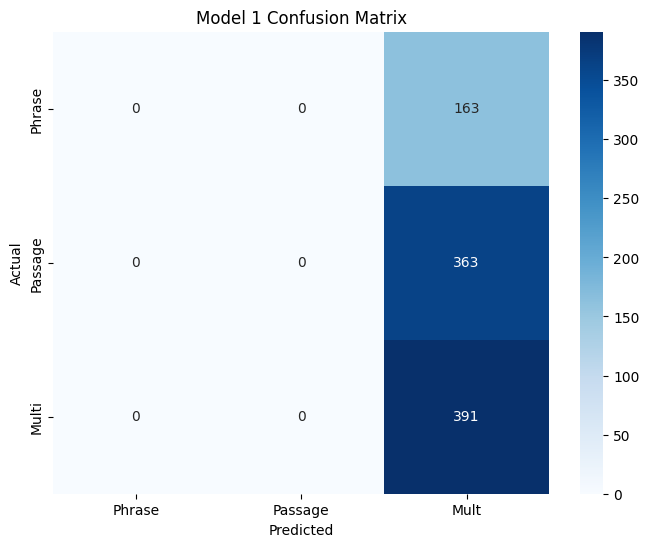

In [ ]:
#Confusion Matrix
cm1 = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Phrase', 'Passage', 'Mult'], yticklabels=['Phrase', 'Passage', 'Multi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model 1 Confusion Matrix')
plt.show()

In [ ]:
#Binarize labels
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])


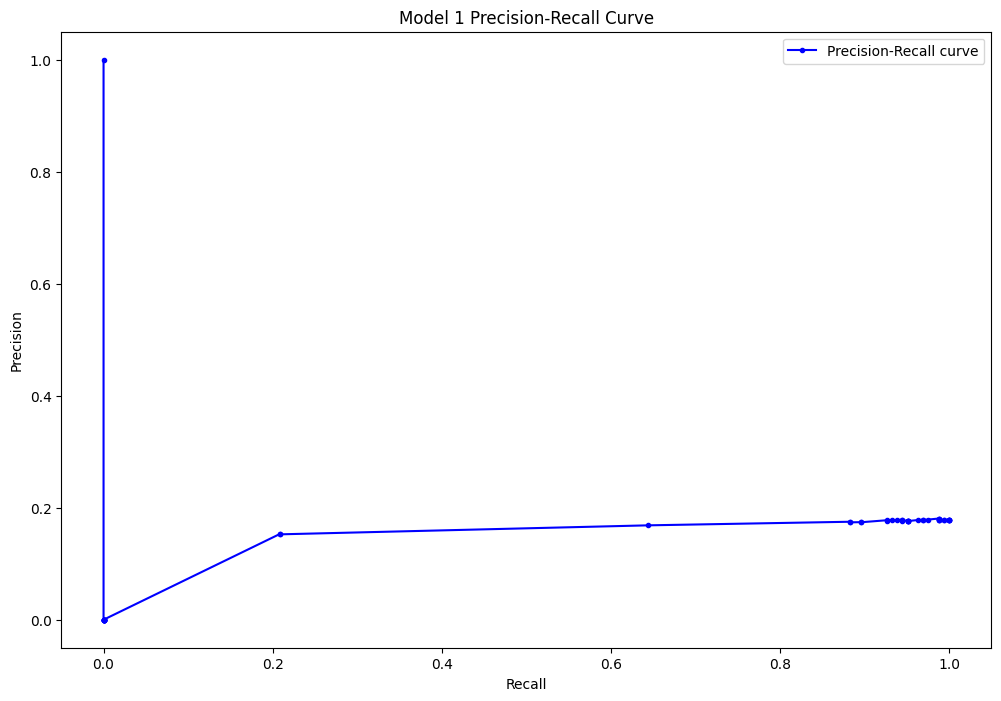

In [ ]:
#Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_bin[:,0], y_pred[:,0])

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, color='blue', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Model 1 Precision-Recall Curve')
plt.show()

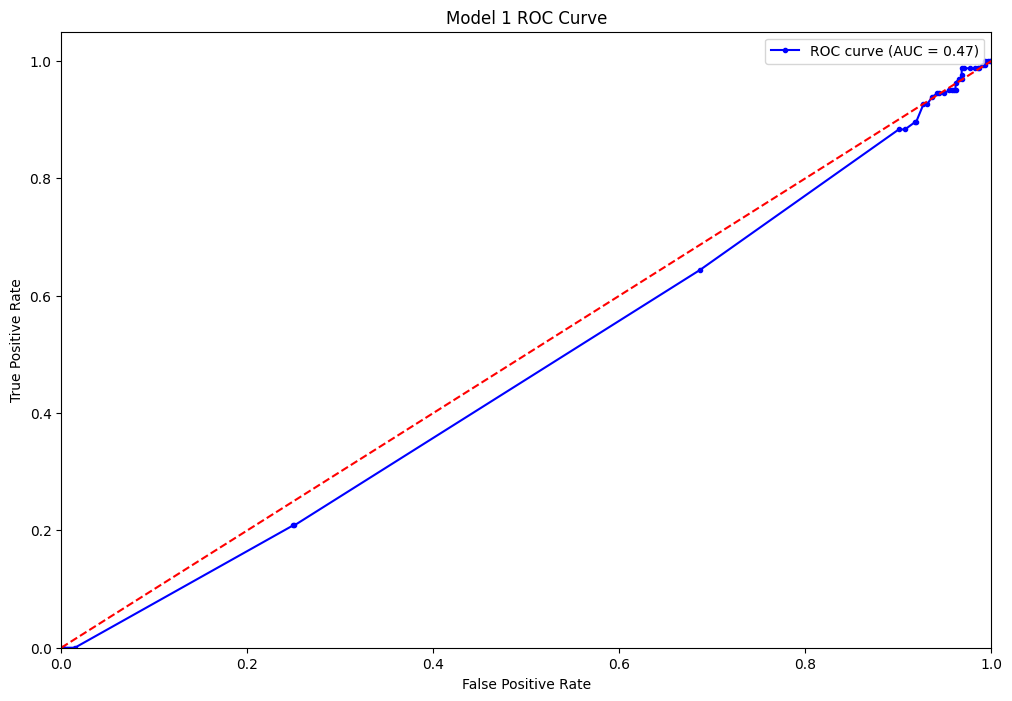

In [ ]:
#ROC and AUC Curve
fpr, tpr, _ = roc_curve(y_test_bin[:,0], y_pred[:,0])

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', marker='.', label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('Model 1 ROC Curve')
plt.show()

In [ ]:
#LSTM Model for classification

def lstm_model(hp, include_transformer=False):
  input_layer = Input(shape=(100,))

  #Hyperparameters for Embedding and LSTM
  embedding_dim = hp.Int('embedding_dim', min_value=100, max_value=300, step=50)
  embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim)(input_layer)

  #Bidrectional LSTM Layer
  lstm_units = hp.Int('lstm_units', min_value=128, max_value=512, step=64)
  lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)

  #Attention layer
  attention_layer = Attention()([lstm_layer, lstm_layer])
  context_vector = Concatenate(axis = -1)([lstm_layer, attention_layer])

  #Transformer layer
  if include_transformer:
    def transformer_block(inputs, num_heads, ff_dim):
      # Multihead Attention
      attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)

      attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

      # Feedforward layer
      ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(attention_output)
      ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)

      transformer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

      return transformer_output

    transformer_output = transformer_block(context_vector, num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
                                           ff_dim=hp.Int('ff_dim', min_value=64, max_value=512, step=128))
  else:
    transformer_output = context_vector


  #Global pooling
  pooled_output = GlobalAveragePooling1D()(transformer_output)

  #Dense layers
  dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
  dense_layer = Dense(dense_units, activation='relu')(pooled_output)

  #Dropout
  dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
  dropout_layer = Dropout(dropout_rate)(dense_layer)

  #Batch Normalization
  batch_norm_layer = LayerNormalization()(dropout_layer)

  #Output layer
  output_layer = Dense(3, activation='softmax')(batch_norm_layer)

  #The Model
  model = Model(inputs=input_layer, outputs=output_layer)

  #Compiler
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def cnn_lstm_model(hp, include_transformer=False):
  input_layer = tf.keras.layers.Input(shape=(100,))

  #Hyperparameters for Embedding and LSTM
  embedding_dim = hp.Int('embedding_dim', min_value=100, max_value=300, step=50)
  embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim)(input_layer)

  #CNN layers
  cnn_filters = hp.Int('cnn_filters', min_value=32, max_value=128, step=32)
  cnn_kernel_size = hp.Int('cnn_kernel_size', min_value=3, max_value=5, step=1)
  conv1 = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu')(embedding_layer)
  #conv2 = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu')(conv1)

  pool = MaxPooling1D(pool_size=2)(conv1)

  #LSTM layers
  lstm_units = hp.Int('lstm_units', min_value=64, max_value=512, step=64)
  lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(pool)

  #Attention layer
  attention_layer = Attention()([lstm_layer, lstm_layer])
  context_vector = tf.keras.layers.Concatenate(axis = -1)([lstm_layer, attention_layer])

  #Transformer layer
  if include_transformer:
    def transformer_block(inputs, num_heads, ff_dim):
      # Multihead Attention
      attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)

      attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

      # Feedforward layer
      ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(attention_output)
      ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)

      transformer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

      return transformer_output

    transformer_output = transformer_block(context_vector, num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
                                           ff_dim=hp.Int('ff_dim', min_value=64, max_value=512, step=128))
  else:
    transformer_output = context_vector

  #Global pooling for dimesion reduction
  pool2 = GlobalAveragePooling1D()(transformer_output)


  #Connected dense layer
  dense_layer = Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(pool2)

  #Dropoutlayer
  dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
  dropout_layer = Dropout(dropout_rate)(dense_layer)

  #Output layer
  output_layer = Dense(3, activation='softmax')(dropout_layer)

  #The Model
  model = Model(inputs=input_layer, outputs=output_layer)

  #Compiler
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
#ytest
y_test_classes = np.argmax(y_test, axis=1)

LSTM MODEL

In [ ]:
#The Tuner
lstm_tuner = kt.Hyperband(lstm_model, objective='val_accuracy', max_epochs=5, factor=3,
                             directory='lstm_tuning1', project_name='lstm_tuning', overwrite=True)

In [ ]:
#Hyperparameter search
lstm_tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 03m 49s]
val_accuracy: 0.46986302733421326

Best val_accuracy So Far: 0.46986302733421326
Total elapsed time: 00h 29m 56s


In [ ]:
best_lstmmodel = lstm_tuner.get_best_models(num_models=1)[0]
best_hp_lstm = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hp_lstm.values)

Best Hyperparameters: {'embedding_dim': 150, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:

lstm_history = best_lstmmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - accuracy: 0.4255 - loss: 1.0478 - val_accuracy: 0.4178 - val_loss: 1.0454
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 445ms/step - accuracy: 0.4511 - loss: 1.0283 - val_accuracy: 0.3945 - val_loss: 1.0631
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.4797 - loss: 1.0206 - val_accuracy: 0.4123 - val_loss: 1.0259
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.6056 - loss: 0.8920 - val_accuracy: 0.4603 - val_loss: 1.2688
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 445ms/step - accuracy: 0.7475 - loss: 0.6138 - val_accuracy: 0.5219 - val_loss: 1.5893
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - accuracy: 0.8925 - loss: 0.2832 - val_accuracy: 0.5000 - val_loss: 2.0516
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 444ms/step - accuracy: 0.9543 - loss: 0.1394 - val_accuracy: 0.4945 - val_loss: 2.7753
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.9765 - loss: 0.0882 - val_accu

In [ ]:
lstm_test, lstm_test_acc = best_lstmmodel.evaluate(X_test, y_test)
print("Test Accuracy:", lstm_test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.4940 - loss: 3.4413
Test Accuracy: 0.5081788301467896


In [ ]:
y_predlstm = best_lstmmodel.predict(X_test)
y_predlstm_classes = np.argmax(y_predlstm, axis=1)


print("Accuracy:", accuracy_score(y_test_classes, y_predlstm_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_predlstm_classes))



29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step
Accuracy: 0.5081788440567067
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.18      0.26       163
           1       0.48      0.62      0.54       363
           2       0.54      0.54      0.54       391

    accuracy                           0.51       917
   macro avg       0.50      0.45      0.45       917
weighted avg       0.51      0.51      0.49       917



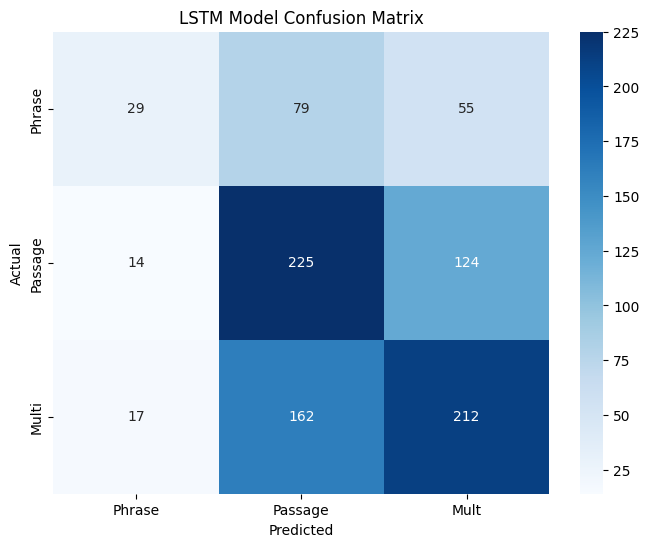

In [ ]:
#Confusion Matrix
lstm_cm = confusion_matrix(y_test_classes, y_predlstm_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Phrase', 'Passage', 'Mult'], yticklabels=['Phrase', 'Passage', 'Multi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Model Confusion Matrix')
plt.show()

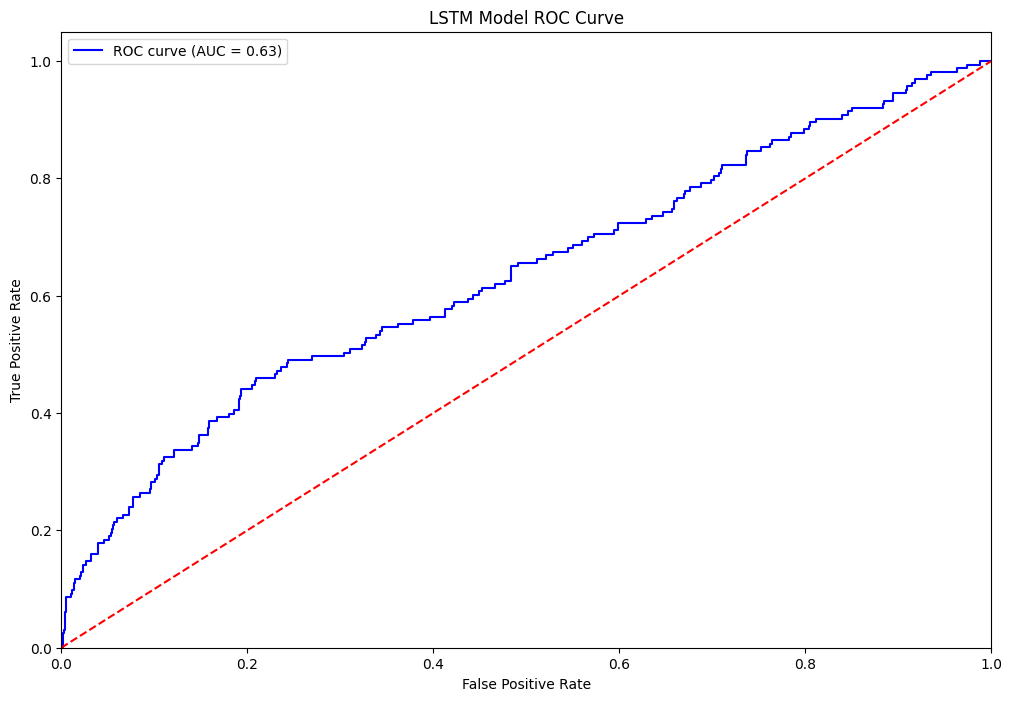

In [ ]:
#ROC-AUC
lstm_fpr, lstm_tpr, _ = roc_curve(y_test_bin[:,0], y_predlstm[:,0])
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)

plt.figure(figsize=(12, 8))
plt.plot(lstm_fpr, lstm_tpr, color='blue', label=f'ROC curve (AUC = {lstm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('LSTM Model ROC Curve')
plt.show()

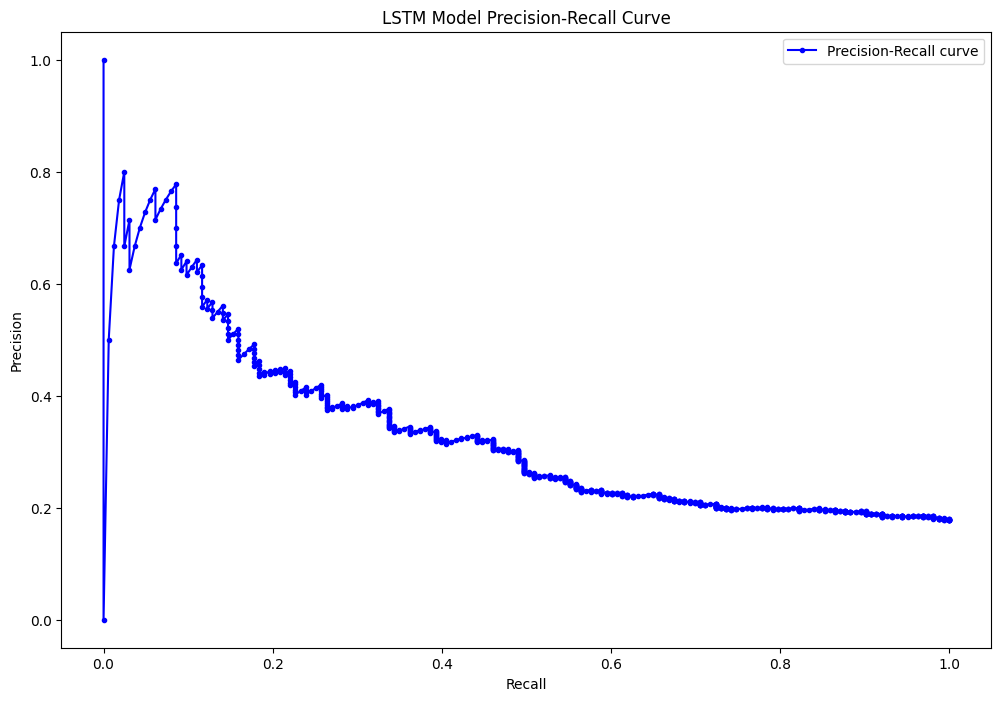

In [ ]:
#Precision-Recall curve
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test_bin[:,0], y_predlstm[:,0])

plt.figure(figsize=(12, 8))
plt.plot(lstm_recall, lstm_precision, color='blue', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('LSTM Model Precision-Recall Curve')
plt.show()

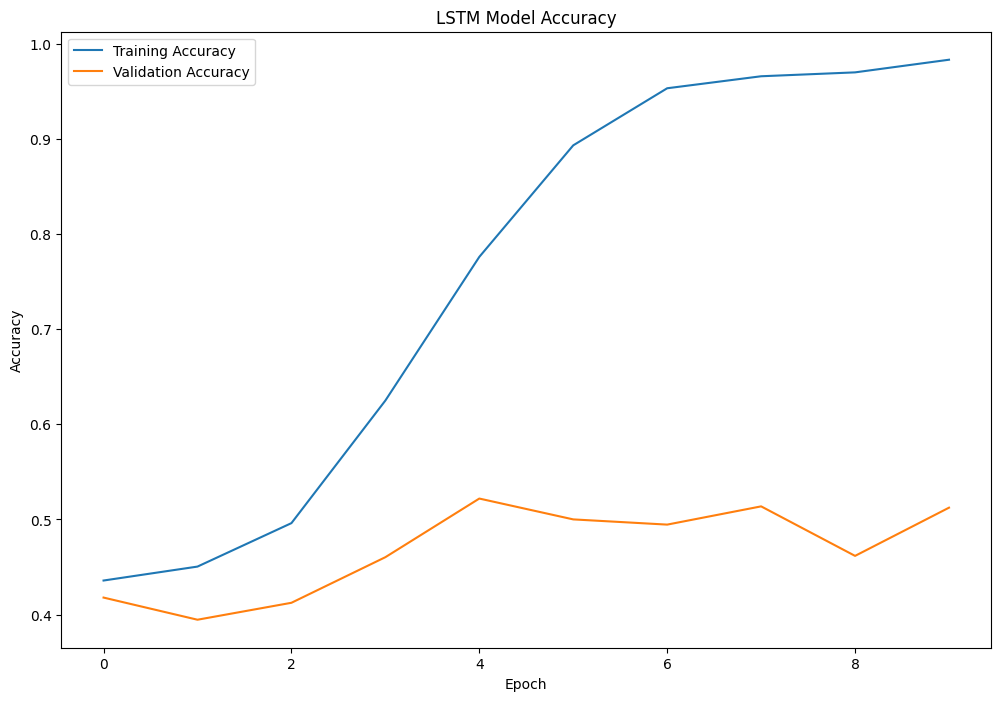

In [ ]:
#Accuracy Plot
plt.figure(figsize=(12, 8))
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Model Accuracy')
plt.show()

CNN-LSTM MODEL

In [ ]:
#The Tuner
cnnlstm_tuner = kt.Hyperband(cnn_lstm_model, objective='val_accuracy', max_epochs=5, factor=3,
                             directory='cnnlstm_tuning1', project_name='cnnlstm_tuning', overwrite=True)

In [ ]:
cnnlstm_tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 09m 19s]
val_accuracy: 0.4178082048892975

Best val_accuracy So Far: 0.47534245252609253
Total elapsed time: 00h 32m 04s


In [ ]:
best_cnnlstm = cnnlstm_tuner.get_best_models(num_models=1)[0]
best_hp_cnnlstm = cnnlstm_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hp_cnnlstm.values)

Best Hyperparameters: {'embedding_dim': 150, 'cnn_filters': 128, 'cnn_kernel_size': 4, 'lstm_units': 320, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0003'}


In [ ]:

cnnlstm_history = best_cnnlstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 627ms/step - accuracy: 0.9797 - loss: 0.0773 - val_accuracy: 0.4507 - val_loss: 2.9044
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 629ms/step - accuracy: 0.9946 - loss: 0.0183 - val_accuracy: 0.4534 - val_loss: 3.8158
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.4589 - val_loss: 4.2763
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 613ms/step - accuracy: 0.9985 - loss: 0.0039 - val_accuracy: 0.4616 - val_loss: 4.9114
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 628ms/step - accuracy: 0.9971 - loss: 0.0192 - val_accuracy: 0.4616 - val_loss: 5.0959
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 625ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 0.4479 - val_loss: 4.1198
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 615ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.4479 - val_loss: 4.9699
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 594ms/step - accuracy: 0.9999 - loss: 6.4451e-04 - val_

In [ ]:
cnnlstm_test_loss, cnnlstm_test_acc = best_cnnlstm.evaluate(X_test, y_test)
print("Test Accuracy:", cnnlstm_test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.4814 - loss: 5.8719
Test Accuracy: 0.49618321657180786


In [ ]:
y_predcnnlstm = best_cnnlstm.predict(X_test)
y_predcnnlstm_classes = np.argmax(y_predcnnlstm, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_predcnnlstm_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_predcnnlstm_classes))

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
Accuracy: 0.4961832061068702
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.26      0.30       163
           1       0.51      0.55      0.53       363
           2       0.52      0.55      0.53       391

    accuracy                           0.50       917
   macro avg       0.46      0.45      0.45       917
weighted avg       0.49      0.50      0.49       917



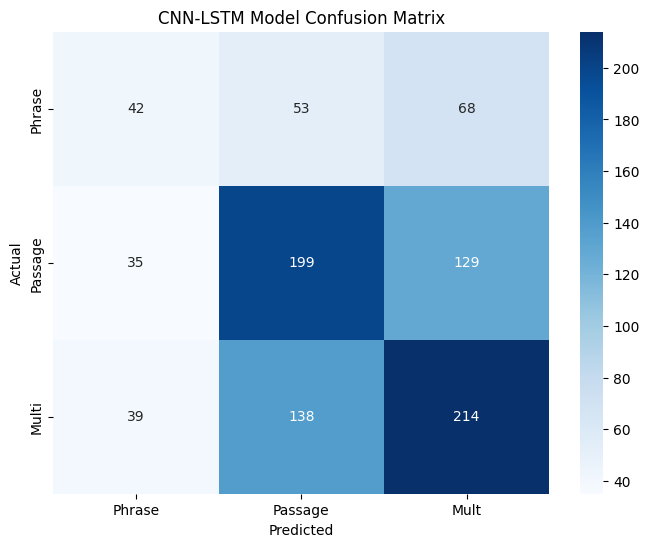

In [ ]:
#Confusion Matrix
cnnlstm_cm = confusion_matrix(y_test_classes, y_predcnnlstm_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cnnlstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Phrase', 'Passage', 'Mult'], yticklabels=['Phrase', 'Passage', 'Multi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-LSTM Model Confusion Matrix')
plt.show()


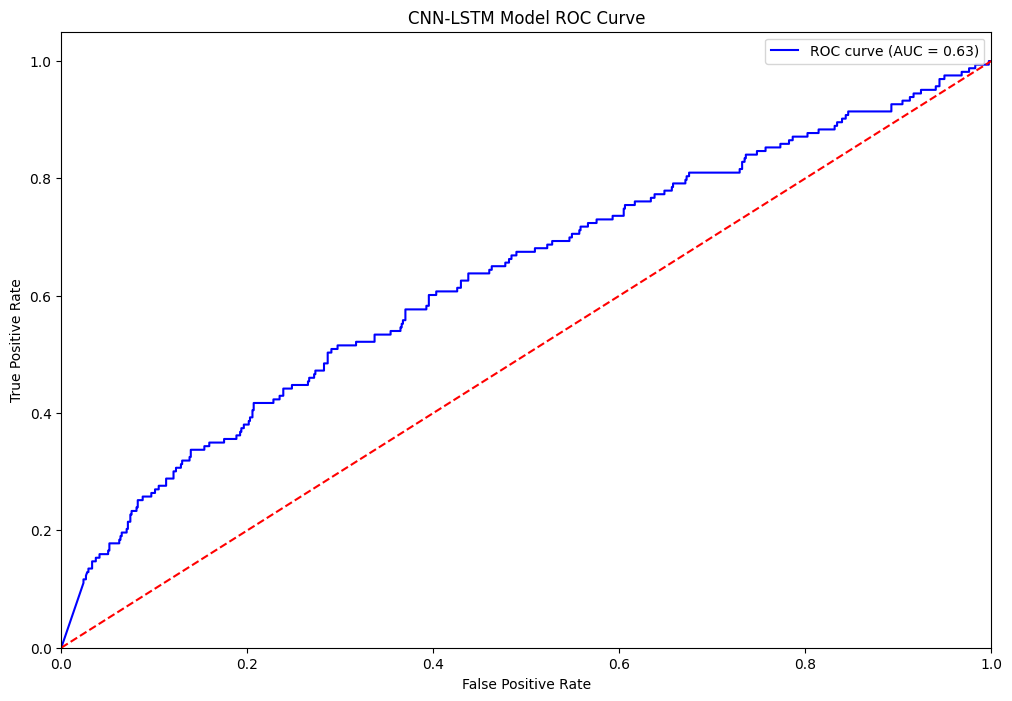

In [ ]:
#ROC-AUC
cnnlstm_fpr, cnnlstm_tpr, _ = roc_curve(y_test_bin[:,0], y_predcnnlstm[:,0])
cnnlstm_roc_auc = auc(cnnlstm_fpr, cnnlstm_tpr)

plt.figure(figsize=(12, 8))
plt.plot(cnnlstm_fpr, cnnlstm_tpr, color='blue', label=f'ROC curve (AUC = {cnnlstm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('CNN-LSTM Model ROC Curve')
plt.show()

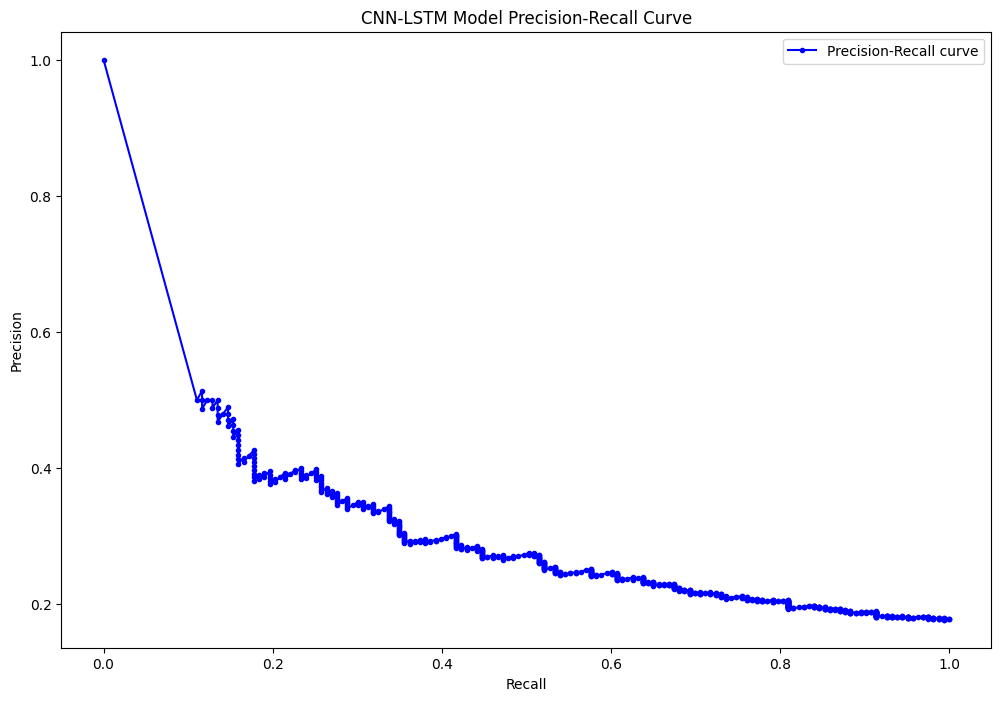

In [ ]:
#Precision-Recall curve
cnnlstm_precision, cnnlstm_recall, _ = precision_recall_curve(y_test_bin[:,0], y_predcnnlstm[:,0])

plt.figure(figsize=(12, 8))
plt.plot(cnnlstm_recall, cnnlstm_precision, color='blue', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('CNN-LSTM Model Precision-Recall Curve')
plt.show()

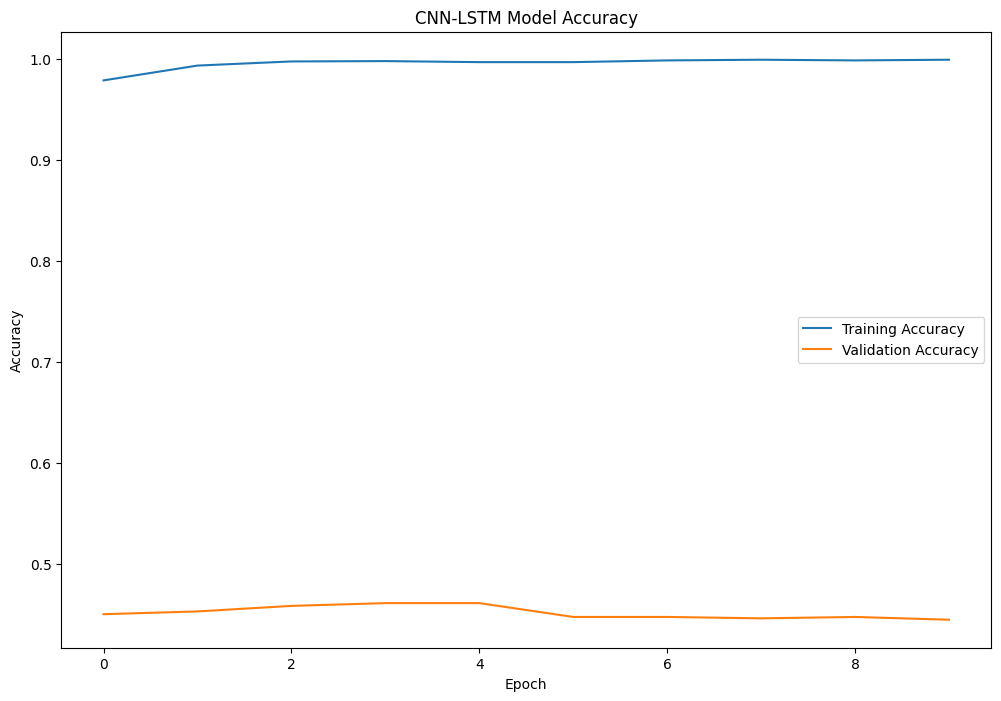

In [ ]:
#Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(cnnlstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnnlstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN-LSTM Model Accuracy')
plt.show()

LSTM WITH TRANSFORMER

In [ ]:
lstm_transformer_tuner = kt.Hyperband(
    lambda hp: lstm_model(hp, include_transformer=True),
    objective='val_accuracy', max_epochs=5, factor=3,
    directory='lstm_transformer_tuning', project_name='lstm_transformer_tuning', overwrite=True)

In [ ]:
#Hyperparameter search
lstm_transformer_tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 09m 20s]
val_accuracy: 0.41643837094306946

Best val_accuracy So Far: 0.4205479323863983
Total elapsed time: 02h 21m 42s


In [ ]:
best_lstm_transformer = lstm_transformer_tuner.get_best_models(num_models=1)[0]
best_hp_lstm_transformer = lstm_transformer_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hp_lstm_transformer.values)

Best Hyperparameters: {'embedding_dim': 150, 'lstm_units': 384, 'num_heads': 4, 'ff_dim': 320, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:

lstm_transformer_history = best_lstm_transformer.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.3726 - loss: 1.1059 - val_accuracy: 0.3945 - val_loss: 1.0619
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.4015 - loss: 1.0564 - val_accuracy: 0.4192 - val_loss: 1.0535
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.3959 - loss: 1.0573 - val_accuracy: 0.4192 - val_loss: 1.0530
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.4274 - loss: 1.0396 - val_accuracy: 0.4192 - val_loss: 1.0506
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.4221 - loss: 1.0416 - val_accuracy: 0.4616 - val_loss: 1.0537
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.4881 - loss: 1.0101 - val_accuracy: 0.4932 - val_loss: 1.0880
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.6722 - loss: 0.8112 - val_accuracy: 0.4753 - val_loss: 1.1464
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.7610 - loss: 0.6494 - val_accuracy: 0.4753 - v

In [ ]:
lstmtransformer_test_loss, lstmtransformer_test_acc = best_lstm_transformer.evaluate(X_test, y_test)
print("Test Accuracy:", lstmtransformer_test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 695ms/step - accuracy: 0.4627 - loss: 2.3117
Test Accuracy: 0.48309704661369324


In [ ]:
y_predlstmtrans = best_lstm_transformer.predict(X_test)
y_predlstmtrans_classes = np.argmax(y_predlstmtrans, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_predlstmtrans_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_predlstmtrans_classes))

29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 901ms/step
Accuracy: 0.4830970556161396
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.23      0.24       163
           1       0.56      0.42      0.48       363
           2       0.51      0.65      0.57       391

    accuracy                           0.48       917
   macro avg       0.44      0.43      0.43       917
weighted avg       0.48      0.48      0.48       917



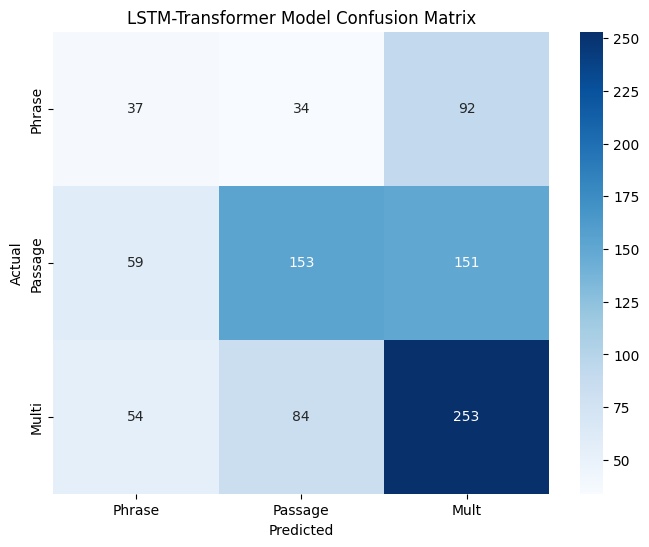

In [ ]:
#Confusion matrix
lstmtrans_cm = confusion_matrix(y_test_classes, y_predlstmtrans_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(lstmtrans_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Phrase', 'Passage', 'Mult'], yticklabels=['Phrase', 'Passage', 'Multi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM-Transformer Model Confusion Matrix')
plt.show()

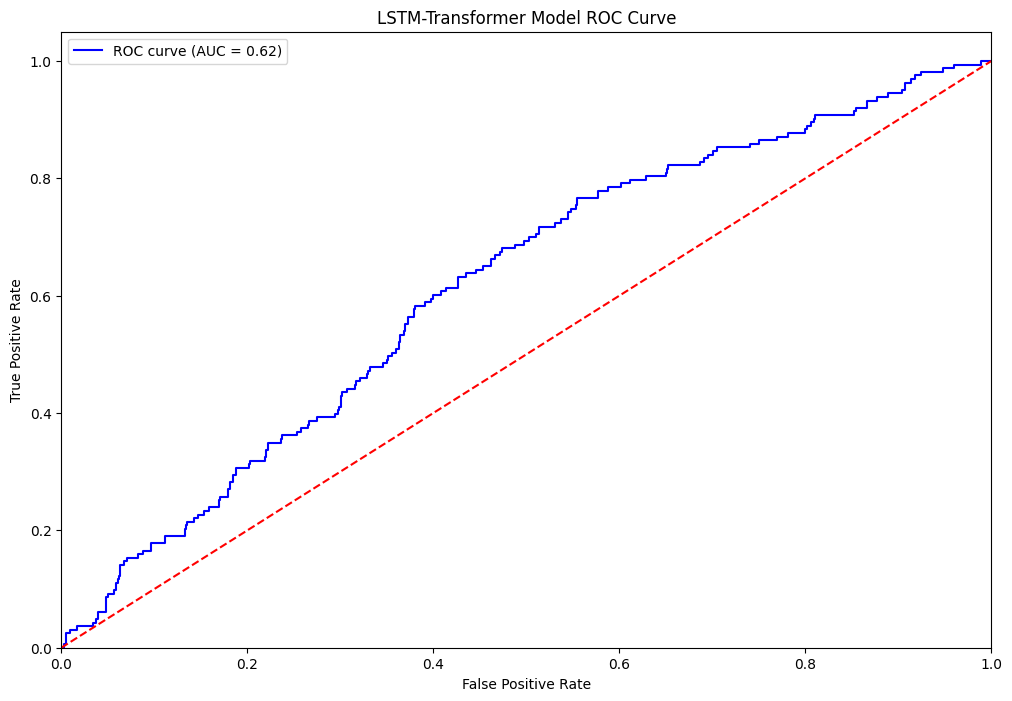

In [ ]:
#ROC-AUC
lstmtrans_fpr, lstmtrans_tpr, _ = roc_curve(y_test_bin[:,0], y_predlstmtrans[:,0])
lstmtrans_roc_auc = auc(lstmtrans_fpr, lstmtrans_tpr)

plt.figure(figsize=(12, 8))
plt.plot(lstmtrans_fpr, lstmtrans_tpr, color='blue', label=f'ROC curve (AUC = {lstmtrans_roc_auc:.2f})')
plt.plot([0, 1], [0,1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('LSTM-Transformer Model ROC Curve')
plt.show()

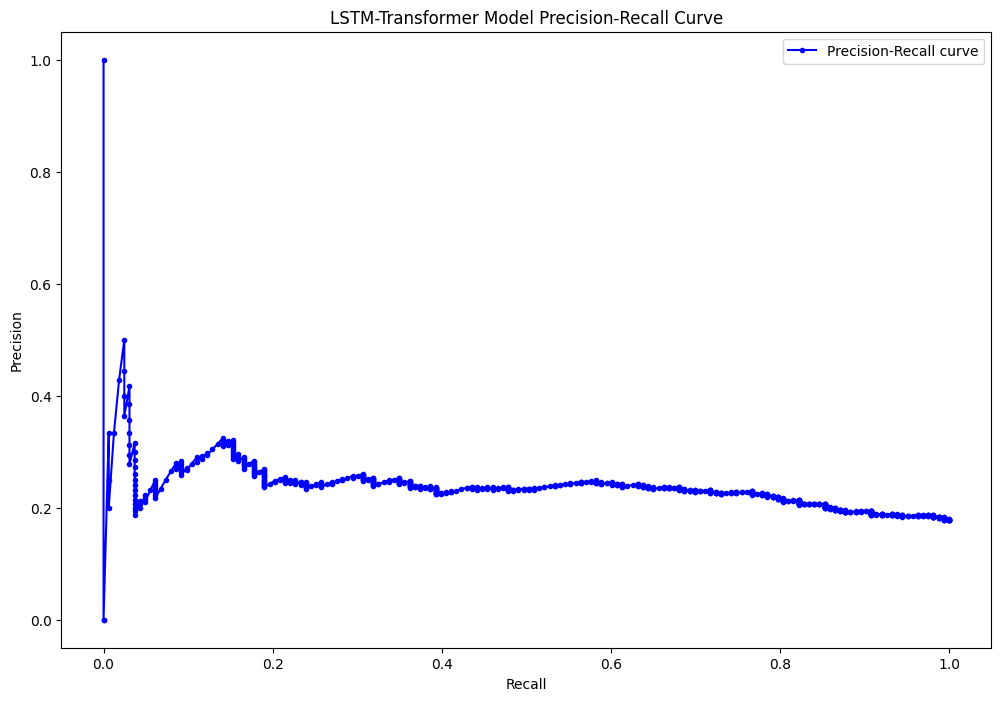

In [ ]:
#Precision-Recall
lstmtrans_precision, lstmtrans_recall, _ = precision_recall_curve(y_test_bin[:,0], y_predlstmtrans[:,0])

plt.figure(figsize=(12, 8))
plt.plot(lstmtrans_recall, lstmtrans_precision, color='blue', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('LSTM-Transformer Model Precision-Recall Curve')
plt.show()

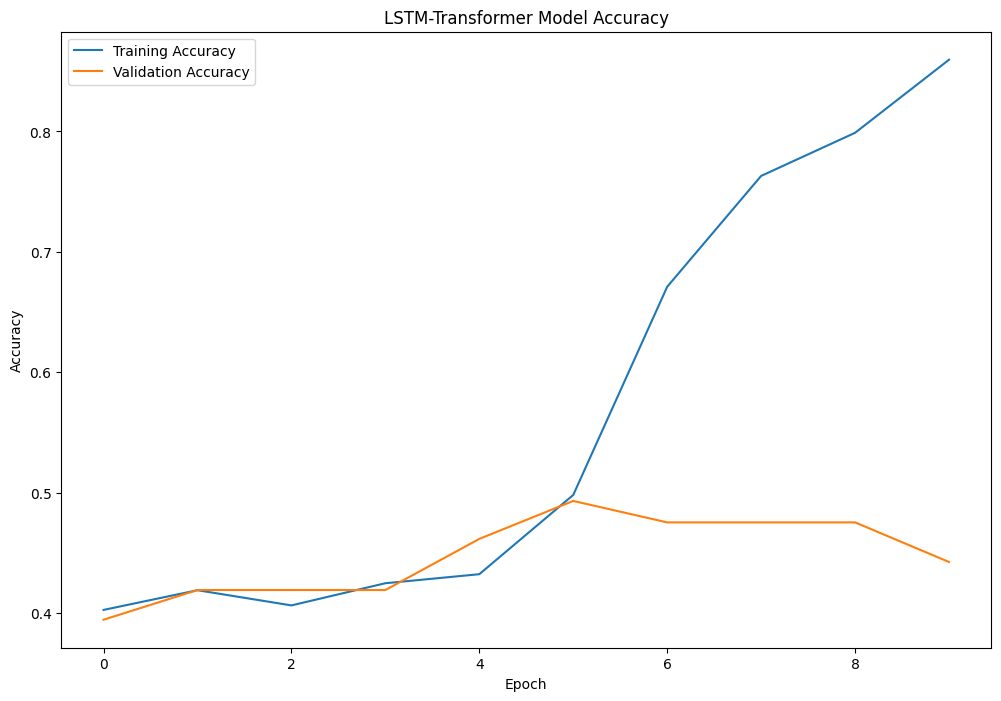

In [ ]:
#Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(lstm_transformer_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_transformer_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM-Transformer Model Accuracy')
plt.show()

CNN-LSTM WITH TRANSFORMER

In [ ]:
#CNN LSTM WITH TRANSFORMER
cnnlstm_transformer_tuner = kt.Hyperband(
    lambda hp: cnn_lstm_model(hp, include_transformer=True),
    objective='val_accuracy', max_epochs=5, factor=3,
    directory='cnnlstm_transformer_tuning', project_name='cnnlstm_transformer_tuning', overwrite=True)

In [ ]:
cnnlstm_transformer_tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 25m 21s]
val_accuracy: 0.41643837094306946

Best val_accuracy So Far: 0.48493149876594543
Total elapsed time: 01h 43m 08s


In [ ]:
best_cnnlstm_transformer = cnnlstm_transformer_tuner.get_best_models(num_models=1)[0]
best_hp_cnnlstm_transformer = cnnlstm_transformer_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hp_cnnlstm_transformer.values)

Best Hyperparameters: {'embedding_dim': 250, 'cnn_filters': 96, 'cnn_kernel_size': 5, 'lstm_units': 64, 'num_heads': 4, 'ff_dim': 64, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
cnnlstm_transformer_history = best_cnnlstm_transformer.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.8128 - loss: 0.4965 - val_accuracy: 0.4781 - val_loss: 1.5035
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.9457 - loss: 0.1690 - val_accuracy: 0.4630 - val_loss: 1.8576
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.9823 - loss: 0.0655 - val_accuracy: 0.4411 - val_loss: 2.7417
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9961 - loss: 0.0161 - val_accuracy: 0.4425 - val_loss: 2.9321
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9965 - loss: 0.0117 - val_accuracy: 0.4849 - val_loss: 3.0110
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 0.4438 - val_loss: 3.1506
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.9977 - loss: 0.0147 - val_accuracy: 0.4603 - val_loss: 3.3830
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accu

In [ ]:
cnnlstmtransformer_test_loss, cnnlstmtransformer_test_acc = best_cnnlstm_transformer.evaluate(X_test, y_test)
print("Test Accuracy:", cnnlstmtransformer_test_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4978 - loss: 3.4697
Test Accuracy: 0.4820065498352051


In [ ]:
y_predcnnlstmtrans = best_cnnlstm_transformer.predict(X_test)
y_predcnnlstmtrans_classes = np.argmax(y_predcnnlstmtrans, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_predcnnlstmtrans_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_predcnnlstmtrans_classes))

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step
Accuracy: 0.4820065430752454
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.36      0.34       163
           1       0.52      0.42      0.46       363
           2       0.51      0.60      0.55       391

    accuracy                           0.48       917
   macro avg       0.46      0.46      0.45       917
weighted avg       0.48      0.48      0.48       917



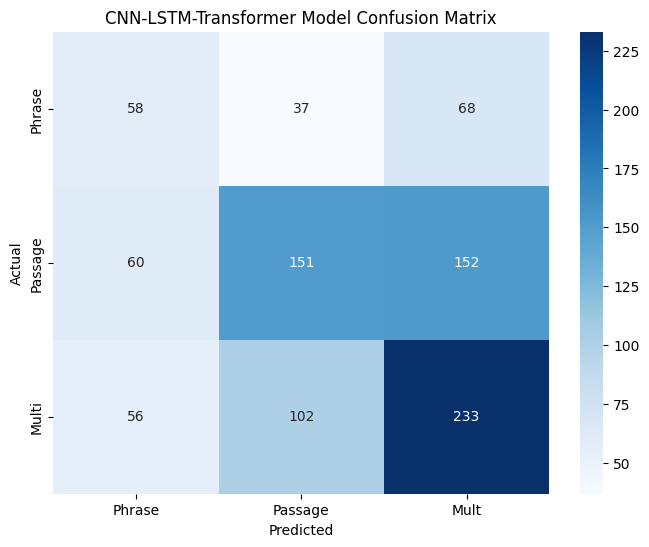

In [ ]:
#Confusion matrix
cnnlstmtrans_cm = confusion_matrix(y_test_classes, y_predcnnlstmtrans_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cnnlstmtrans_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Phrase', 'Passage', 'Mult'], yticklabels=['Phrase', 'Passage', 'Multi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-LSTM-Transformer Model Confusion Matrix')
plt.show()

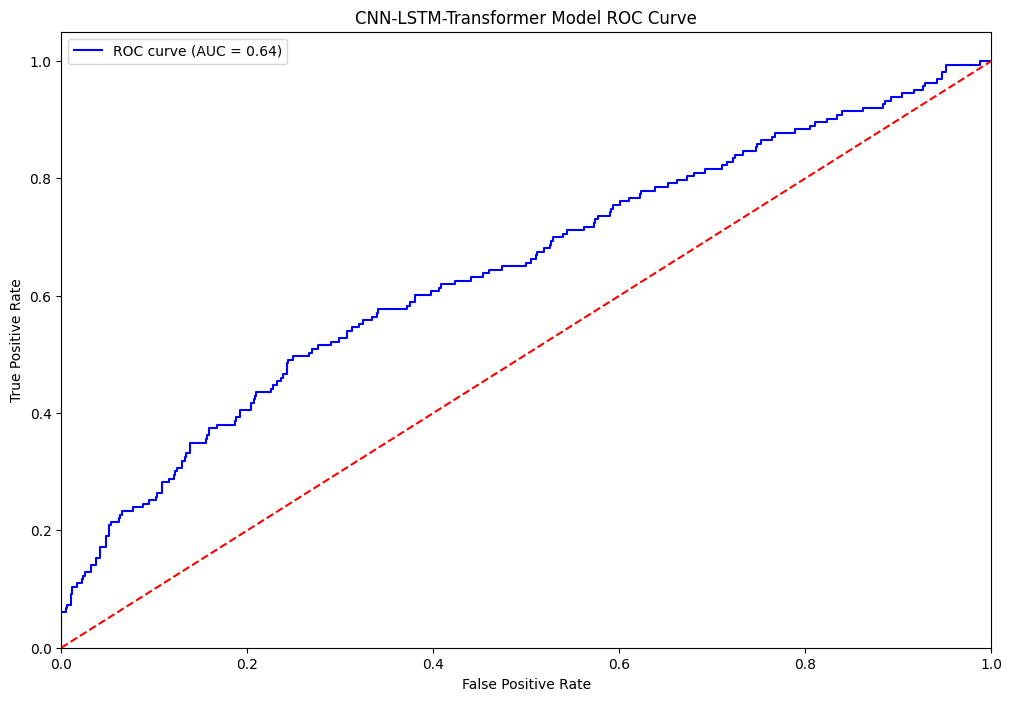

In [ ]:
#ROU-AUC
cnnlstmtrans_fpr, cnnlstmtrans_tpr, _ = roc_curve(y_test_bin[:,0], y_predcnnlstmtrans[:,0])
cnnlstmtrans_roc_auc = auc(cnnlstmtrans_fpr, cnnlstmtrans_tpr)

plt.figure(figsize=(12, 8))
plt.plot(cnnlstmtrans_fpr, cnnlstmtrans_tpr, color='blue', label=f'ROC curve (AUC = {cnnlstmtrans_roc_auc:.2f})')
plt.plot([0, 1], [0,1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('CNN-LSTM-Transformer Model ROC Curve')
plt.show()

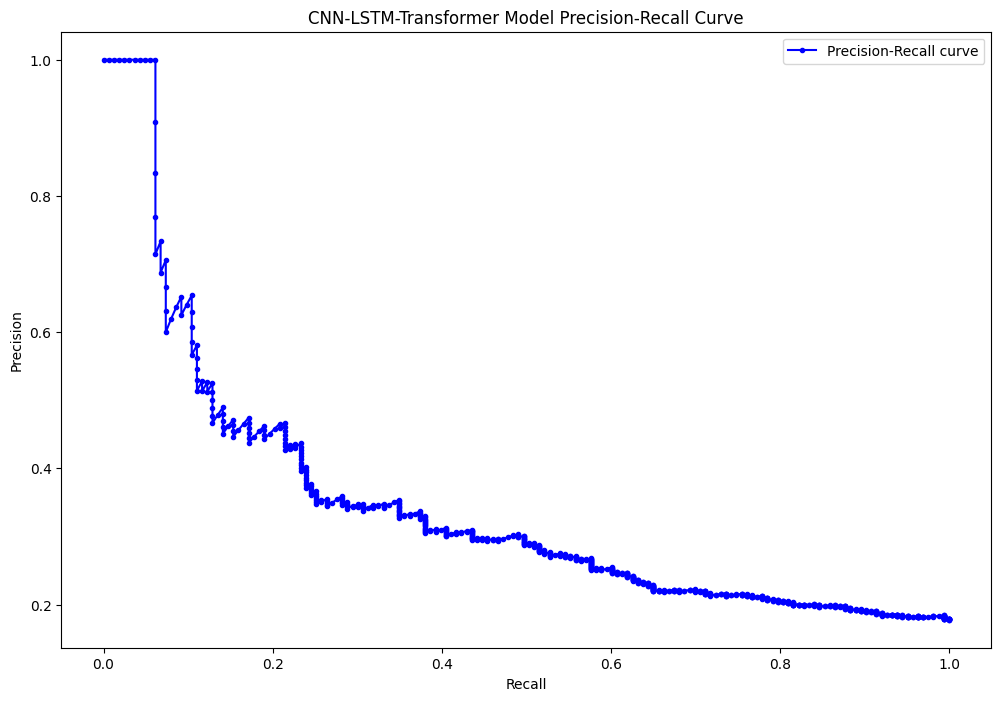

In [ ]:
#Precision_Recall
cnnlstmtrans_precision, cnnlstmtrans_recall, _ = precision_recall_curve(y_test_bin[:,0], y_predcnnlstmtrans[:,0])

plt.figure(figsize=(12, 8))
plt.plot(cnnlstmtrans_recall, cnnlstmtrans_precision, color='blue', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('CNN-LSTM-Transformer Model Precision-Recall Curve')
plt.show()

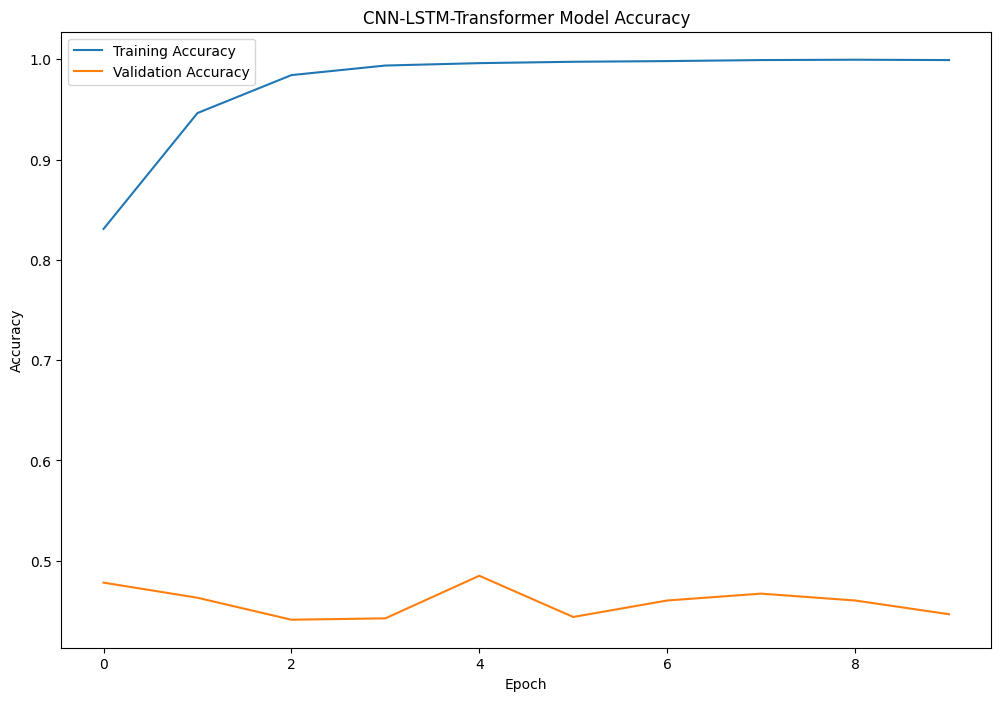

In [ ]:
#Accuracy
plt.figure(figsize=(12, 8))
plt.plot(cnnlstm_transformer_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnnlstm_transformer_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN-LSTM-Transformer Model Accuracy')
plt.show()

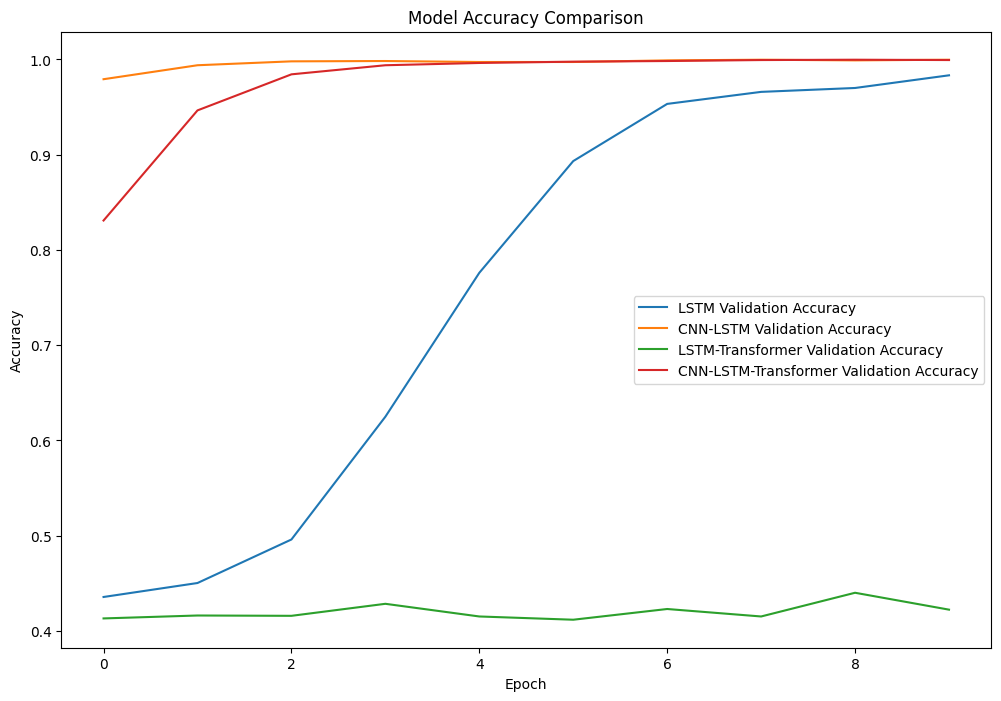

In [ ]:
histories = [lstm_history, cnnlstm_history, lstm_transformer_history, cnnlstm_transformer_history]
labels = ['LSTM', 'CNN-LSTM', 'LSTM-Transformer', 'CNN-LSTM-Transformer']

# Plot the accuracy
plt.figure(figsize=(12, 8))
for history, label in zip(histories, labels):
    plt.plot(history.history['accuracy'], label=f'{label} Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Comparison')
plt.show()

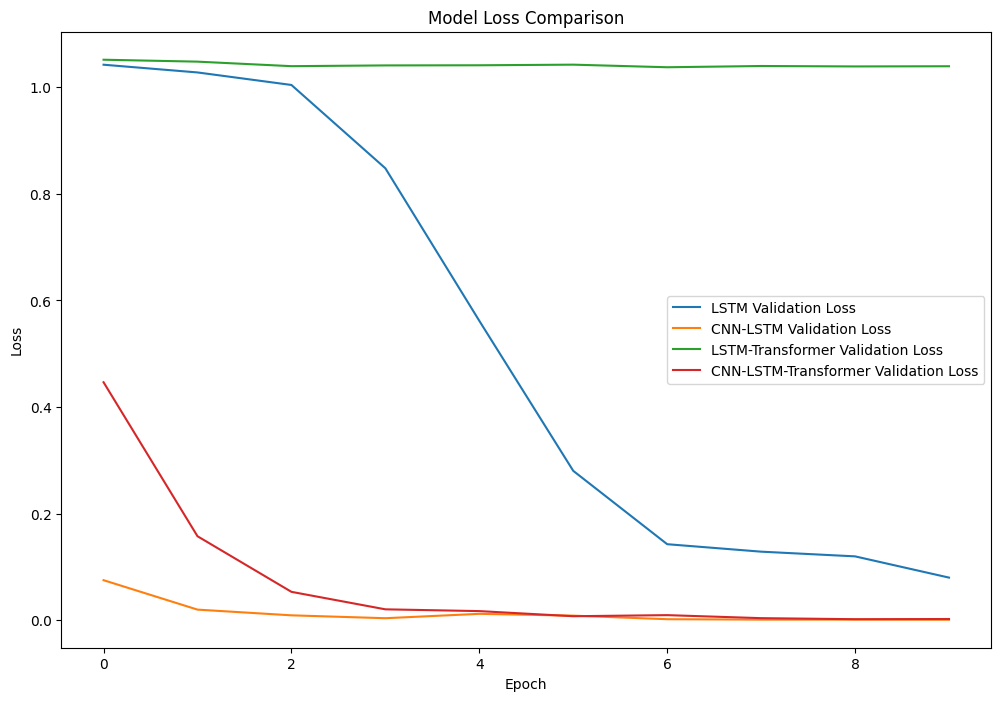

In [ ]:
#Plot Loss
plt.figure(figsize=(12, 8))
for history, label in zip(histories, labels):
    plt.plot(history.history['loss'], label=f'{label} Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Comparison')
plt.show()